# Project name
### Molly Tarter, Onur Gunduz, Daniel Wang



# Introduction
explain agrovoltaics, importance, benefits of our analysis.
explain goal: predict if a location is good based on lat/long coords

# Data Collection
explain dataset we chose, brief explaination of imports and libraries


In [39]:
# Modules
import pandas as pd
import requests
from datetime import datetime, timezone # for time column and EST timezone conversion
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

### Obtaining Data

In [40]:
# API URL and params in case request gets denied
api_url = "https://developer.nrel.gov/api/pvwatts/v8.json" # endpoint with the argivoltaics data
params = {
    'api_key': 'LMpKxIwqBHBN9TJ9x4qtzhR2cD6mQUpZXBAURgbb',
    'system_capacity' : 0.05,
    'module_type' : 0,
    'losses' : 0,
    'array_type' : 0,
    'tilt' : 0,
    'azimuth' : 0,
    'lat' : 38.972360, # Maryland latitude
    'lon' : -76.937732, # Maryland longitude
    'timeframe' : 'hourly' # dataset is hourly, not monthly or annually
}

In [41]:
response = requests.get(api_url, params=params)
json = response.json()
outputs = json['outputs']

# Set start time as Jan 1, 00:00 UTC
length = len(outputs['ac'])
start_time = datetime(datetime.now().year, 1, 1)  # No timezone
times = pd.date_range(start=start_time, periods=length, freq='h')

# Create DataFrame
hourly_data = {
    'Time EST': times,
    'Hourly alternating current system output(Wac)': outputs['ac'],
    'Hourly plane of array irradiance(W/m2)': outputs['poa'],
    'Hourly beam normal irradiance(W/m2)': outputs['dn'],
    'Hourly direct current array output(Wdc)': outputs['dc'],
    'Hourly diffuse irradiance(W/m2)': outputs['df'],
    'Hourly ambient temperature(C)': outputs['tamb'],
    'Hourly module temperature(C)': outputs['tcell'],
    'Hourly windspeed(m/s)': outputs['wspd'],
    'Hourly albedo values': outputs['alb']
}

df = pd.DataFrame(hourly_data)
df.set_index('Time EST', inplace=True)

# Save to CSV
df.to_csv('agrivoltaics.csv', index=True)



# Data Processing

In [42]:
# Data preprocessing
# (a) Import - already done in previous cells
# (b) Parse - already done in previous cells (data types handled by pandas automatically)
# (c) Organize - additional organization steps below

# Check data types of columns
print("DataFrame data types:")
print(df.dtypes)

# Basic statistics of the dataset
print("\nDataset statistics:")
print(df.describe())

# Check for any missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Add some useful derived columns
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek

# Calculate efficiency (DC to AC conversion)
df['System_Efficiency'] = (df['Hourly alternating current system output(Wac)'] /
                          df['Hourly direct current array output(Wdc)'] * 100)

# Sort index to ensure chronological order
df.sort_index(inplace=True)

print("\nUpdated DataFrame columns:")
print(df.columns.tolist())


DataFrame data types:
Hourly alternating current system output(Wac)    float64
Hourly plane of array irradiance(W/m2)           float64
Hourly beam normal irradiance(W/m2)              float64
Hourly direct current array output(Wdc)          float64
Hourly diffuse irradiance(W/m2)                  float64
Hourly ambient temperature(C)                    float64
Hourly module temperature(C)                     float64
Hourly windspeed(m/s)                            float64
Hourly albedo values                             float64
dtype: object

Dataset statistics:
       Hourly alternating current system output(Wac)  \
count                                    8760.000000   
mean                                        8.000985   
std                                        11.763435   
min                                         0.000000   
25%                                         0.000000   
50%                                         0.000000   
75%                                   

# Exploratory Data Analysis

Dataset Dimensions:
Number of entries: 8760
Number of features: 14


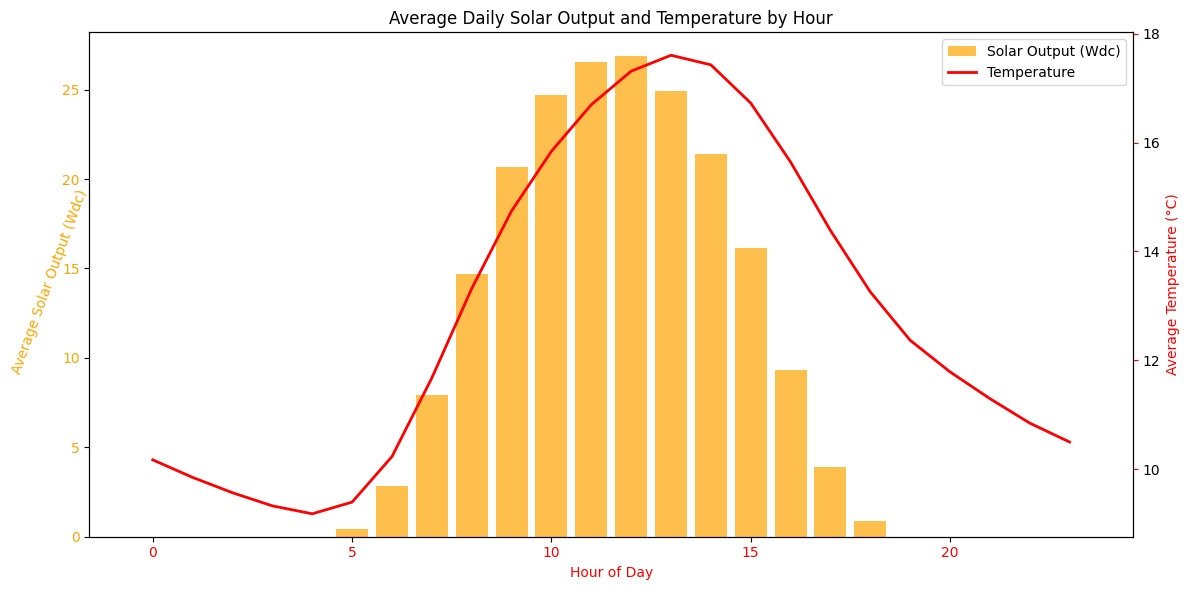

In [43]:
# Basic Data Exploration and Summary Statistics

# 1. Dataset Size and Feature Analysis
print("Dataset Dimensions:")
print(f"Number of entries: {len(df)}")
print(f"Number of features: {len(df.columns)}")

# Create a bar plot showing hourly solar output and temperature
plt.figure(figsize=(12, 6))
daily_avg = df.groupby('Hour').agg({
    'Hourly direct current array output(Wdc)': 'mean',
    'Hourly ambient temperature(C)': 'mean'
})

ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot solar output
ax1.bar(daily_avg.index, daily_avg['Hourly direct current array output(Wdc)'],
        color='orange', alpha=0.7, label='Solar Output (Wdc)')
ax1.set_xlabel('Hour of Day', color='red')
ax1.set_ylabel('Average Solar Output (Wdc)', color='orange', rotation=70)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.tick_params(axis='x', labelcolor='red')

# Plot temperature line
ax2.plot(daily_avg.index, daily_avg['Hourly ambient temperature(C)'],
         color='red', linewidth=2, label='Temperature')
ax2.set_ylabel('Average Temperature (°C)', color='red')
ax2.tick_params(axis='y', color='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Average Daily Solar Output and Temperature by Hour')
plt.tight_layout()
plt.show()

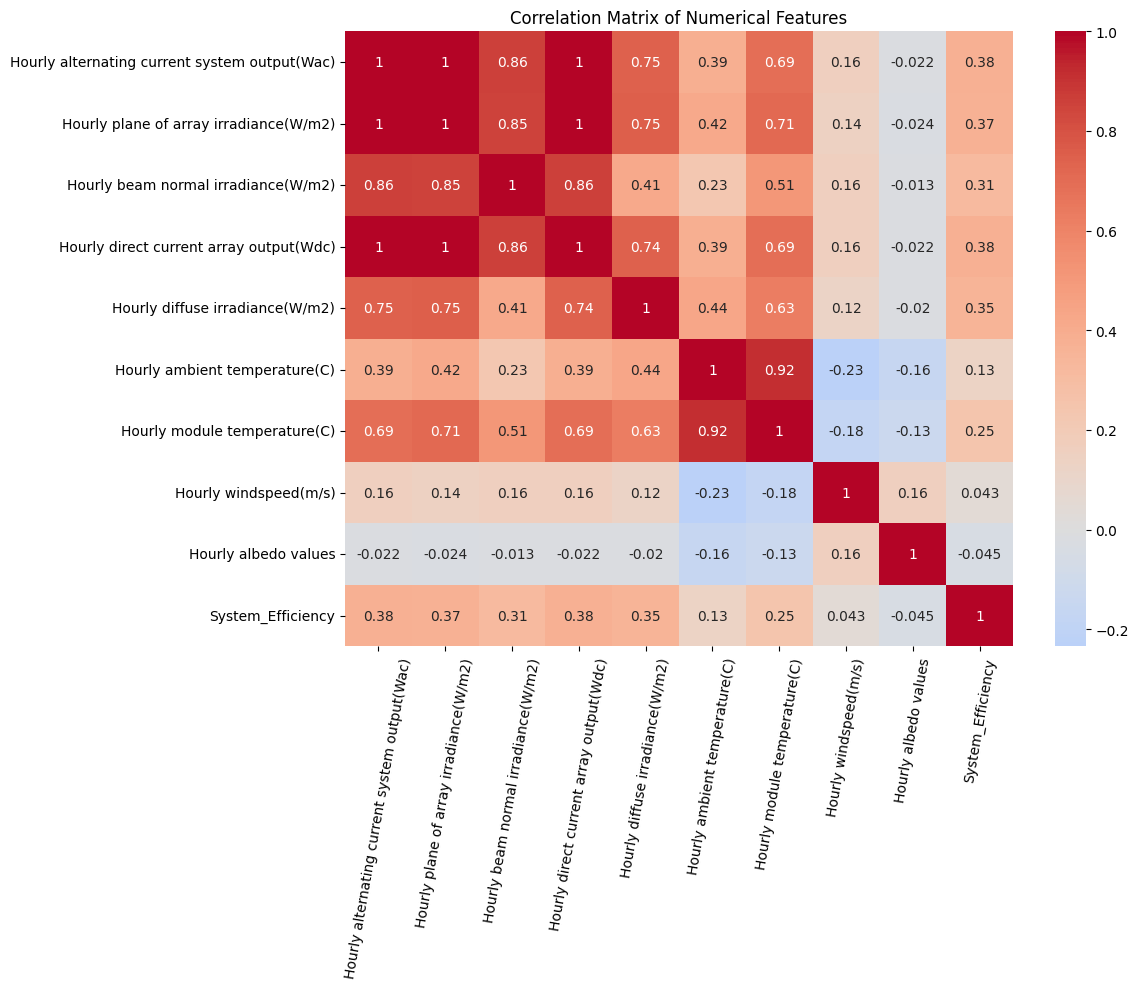


Hypothesis Test - Seasonal Variation in Solar Output:
F-statistic: 44.8229
P-value: 6.1687e-96

Mean DC output by month:
Time EST
1      4.809078
2      5.847926
3      8.677778
4     10.614449
5     11.041595
6     12.275079
7     12.022456
8     10.382448
9      8.882462
10     6.731183
11     5.006049
12     4.088815
Name: Hourly direct current array output(Wdc), dtype: float64

Analysis - Temperature Impact on System Efficiency:
Correlation coefficient: 0.1313
P-value: 3.0865e-18

Hypothesis Test - Morning vs Afternoon Efficiency:
Morning mean efficiency: 92.54%
Afternoon mean efficiency: 93.62%
T-statistic: -3.4992
P-value: 4.7163e-04

Land Use Efficiency Analysis:
Average daily energy production per unit area: 0.19 kWh


In [44]:
# 2. Correlation Analysis
# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

# 1. Analyze seasonal patterns in solar output
seasonal_means = df.groupby(df.index.month)['Hourly direct current array output(Wdc)'].mean()

# Remove any NaN values before running statistical tests
monthly_groups = [group['Hourly direct current array output(Wdc)'].dropna().values
                 for name, group in df.groupby(df.index.month)]
# Only include groups with data
valid_groups = [group for group in monthly_groups if len(group) > 0]

if len(valid_groups) > 1:  # Need at least 2 groups for ANOVA
    f_stat, p_val = stats.f_oneway(*valid_groups)
    print("\nHypothesis Test - Seasonal Variation in Solar Output:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.4e}")
else:
    print("\nInsufficient data for seasonal analysis")

print("\nMean DC output by month:")
print(seasonal_means)

# 2. Correlation between temperature and system efficiency
# Remove rows where either value is NaN
temp_eff_data = df[['Hourly ambient temperature(C)', 'System_Efficiency']].dropna()
if len(temp_eff_data) > 0:
    temp_eff_corr = stats.pearsonr(temp_eff_data['Hourly ambient temperature(C)'],
                                  temp_eff_data['System_Efficiency'])
    print("\nAnalysis - Temperature Impact on System Efficiency:")
    print(f"Correlation coefficient: {temp_eff_corr[0]:.4f}")
    print(f"P-value: {temp_eff_corr[1]:.4e}")
else:
    print("\nInsufficient data for temperature-efficiency correlation")

# 3. Compare morning vs afternoon efficiency
df['Hour'] = df.index.hour
morning = df[df['Hour'].between(6,11)]['System_Efficiency'].dropna()
afternoon = df[df['Hour'].between(12,17)]['System_Efficiency'].dropna()

if len(morning) > 0 and len(afternoon) > 0:
    t_stat, p_val = stats.ttest_ind(morning, afternoon)
    print("\nHypothesis Test - Morning vs Afternoon Efficiency:")
    print(f"Morning mean efficiency: {morning.mean():.2f}%")
    print(f"Afternoon mean efficiency: {afternoon.mean():.2f}%")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.4e}")
else:
    print("\nInsufficient data for morning vs afternoon comparison")

# 4. Calculate land use efficiency metric
daily_energy = df['Hourly alternating current system output(Wac)'].resample('D').sum()
if len(daily_energy) > 0:
    land_efficiency = daily_energy.mean() / 1000  # kWh per day per unit area
    print("\nLand Use Efficiency Analysis:")
    print(f"Average daily energy production per unit area: {land_efficiency:.2f} kWh")
else:
    print("\nInsufficient data for land use efficiency calculation")

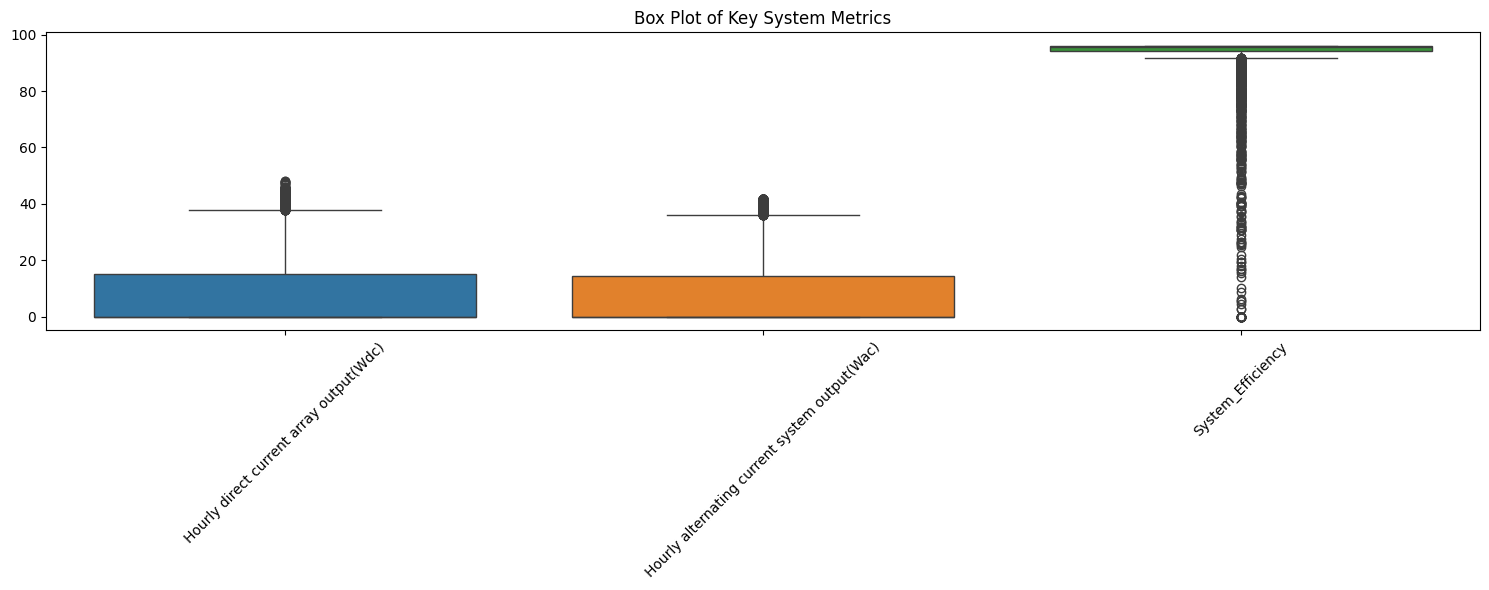


Number of outliers (|z-score| > 3) in each numerical column:
656


In [45]:
# 3. Outlier Analysis using Box Plots
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[['Hourly direct current array output(Wdc)',
                     'Hourly alternating current system output(Wac)',
                     'System_Efficiency']])
plt.title('Box Plot of Key System Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate Z-scores for numerical columns to identify outliers
z_scores = stats.zscore(df[numerical_cols])
outliers = (abs(z_scores) > 3).sum()
print("\nNumber of outliers (|z-score| > 3) in each numerical column:")
print(outliers)

# ML

now that we've looked at the factors, we look across multiple locations to try to see how location affects solar output. firt, we need a new dataset that contains multiple locations. we make a grid using the northmost to southmost points in maryland, and westmost to eastmost points in maryland. because md is not a perfect rectangle, we'll have other points, but thats ok for this purpose

In [96]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from time import sleep
from sklearn.preprocessing import StandardScaler

# Define API parameters
api_url = "https://developer.nrel.gov/api/pvwatts/v8.json"
api_key = 'LMpKxIwqBHBN9TJ9x4qtzhR2cD6mQUpZXBAURgbb'

# make 10x10 grid
lats = np.linspace(37.9, 39.8, 10)
longs = np.linspace(-79.5, -75.0, 10)

locations = []
for lat in lats:
    for long in longs:
        location = {
            'lat': round(lat, 2),
            'long': round(long, 2)
        }
        locations.append(location)


data_list = []
for loc in locations:
    params = {
        'api_key': api_key,
        'system_capacity': 0.05,
        'module_type': 0,
        'losses': 0,
        'array_type': 0,
        'tilt': 0,
        'azimuth': 0,
        'lat': loc['lat'],
        'lon': loc['long'],
        'timeframe': 'hourly'
    }
    response = requests.get(api_url, params=params)
    json = response.json()

    outputs = json['outputs']
    poa_irradiance = outputs['poa']
    avg_poa = np.mean(poa_irradiance)

    data_list.append({
        'lat': loc['lat'],
        'long': loc['long'],
        'avg_poa_irradiance': avg_poa
    })
    sleep(0.3)  # avoid rate limit


locations_df = pd.DataFrame(data_list)
print(locations_df.head())
print(locations_df.describe())



    lat  long  avg_poa_irradiance
0  37.9 -79.5          179.570227
1  37.9 -79.0          181.096270
2  37.9 -78.5          183.757733
3  37.9 -78.0          184.763759
4  37.9 -77.5          185.375743
              lat        long  avg_poa_irradiance
count  100.000000  100.000000          100.000000
mean    38.850000  -77.250000          177.508651
std      0.610597    1.443376            5.151163
min     37.900000  -79.500000          164.208763
25%     38.320000  -78.500000          175.362311
50%     38.850000  -77.250000          178.392278
75%     39.380000  -76.000000          181.097146
max     39.800000  -75.000000          186.603280


we'll use above 75th percentile as suitable. let's use a heatmap to see if location has any correlation with poa irradiance

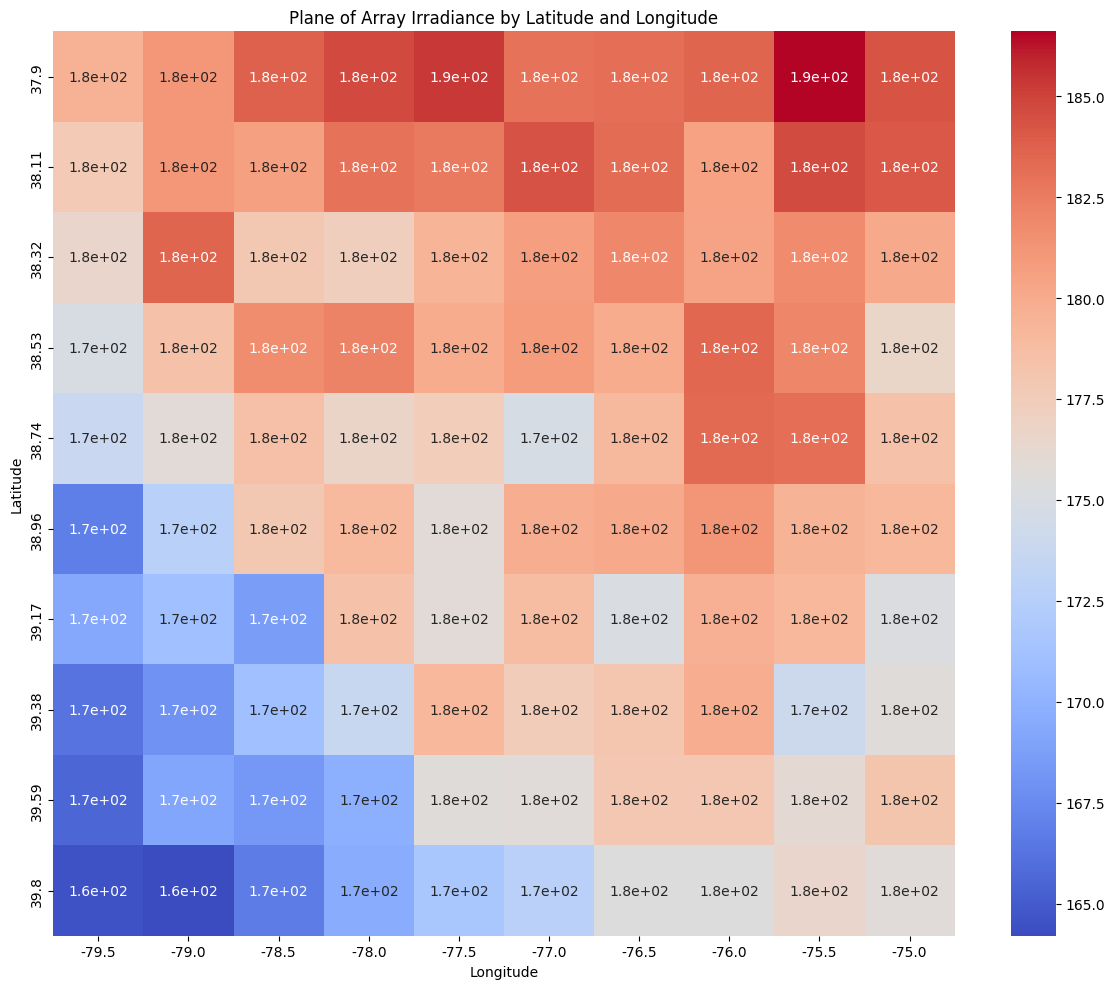

In [85]:
pivoted = locations_df.pivot_table(values='avg_poa_irradiance', index='lat', columns='long')
plt.figure(figsize=(12, 10))
sns.heatmap(pivoted, annot=True, cmap='coolwarm')
plt.title('Plane of Array Irradiance by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


as we can see, there is correlation. now lets try to use an ml model to predict whether a location is good or not. lets start with random forest.

In [105]:
locations_df['is_suitable'] = (locations_df['avg_poa_irradiance'] > 181.097146).astype(int)

X = locations_df[['lat', 'long']]
y = locations_df['is_suitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.33      0.67      0.44         3

    accuracy                           0.75        20
   macro avg       0.63      0.72      0.64        20
weighted avg       0.84      0.75      0.78        20



try random forest but stratified

In [106]:
# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.75      0.60      0.67         5

    accuracy                           0.85        20
   macro avg       0.81      0.77      0.78        20
weighted avg       0.84      0.85      0.84        20



still not too good, try svm

In [107]:
from sklearn.svm import SVC

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.62      1.00      0.77         5

    accuracy                           0.85        20
   macro avg       0.81      0.90      0.83        20
weighted avg       0.91      0.85      0.86        20



slightly worse at class 1 precision, but better at recall